In [26]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep

hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)

In [34]:
# This block is the same as 1_dataset.ipynb

dataset = "/eos/home-g/gkrzmanc/dataset_1408_CLIC_more_particles_DS.root"


class Args:
    def __init__(self):
        self.data_train = [dataset]
        self.data_val = [dataset]
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_data/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train')

In [35]:
iterator = iter(train_data)
g, gt = next(iterator)
g
g.ndata['particle_number'].unique()
gt
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)
g, y = next(iterator)
y.shape
y

=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


tensor([[ 5.3526e-01,  4.0999e-01,  7.3852e-01,  1.7793e+00,  1.5110e+00,
          9.3957e-01,  2.1120e+03],
        [ 8.1056e-01,  5.2707e-01,  2.5532e-01,  2.4873e+01,  2.4873e+01,
          7.3018e-03, -2.2120e+03],
        [-2.7265e-01, -1.3280e-01, -9.5290e-01,  2.1251e+00,  2.1251e+00,
         -3.7696e-04, -2.2120e+03],
        [ 5.4833e-01,  7.4451e-01,  3.8084e-01,  7.0456e-01,  7.0456e-01,
         -1.5442e-04, -2.1100e+02],
        [ 1.2340e-01,  6.8008e-01,  7.2268e-01,  7.0748e-01,  5.0290e-01,
          4.9761e-01,  1.3000e+02],
        [ 3.8019e-01,  6.0919e-01,  6.9595e-01,  4.1049e+00,  4.0747e+00,
          4.9761e-01,  1.3000e+02],
        [-2.7001e-02,  9.9731e-01, -6.8132e-02,  7.7123e+00,  7.6962e+00,
          4.9761e-01,  1.3000e+02],
        [-6.7450e-01, -6.0736e-01, -4.1972e-01,  2.1002e+00,  2.1002e+00,
          2.0073e-04, -2.1100e+02],
        [-2.1590e-01, -3.7028e-01,  9.0348e-01,  5.8596e-01,  3.0940e-01,
          4.9761e-01,  1.3000e+02],
        [-

In [36]:
g

Graph(num_nodes=1383, num_edges=55320,
      ndata_schemes={'h': Scheme(shape=(9,), dtype=torch.float32), 'pos_hits': Scheme(shape=(3,), dtype=torch.float32), 'pos_hits_xyz': Scheme(shape=(3,), dtype=torch.float32), 'pos_hits_norm': Scheme(shape=(3,), dtype=torch.float32), 'hit_type': Scheme(shape=(4,), dtype=torch.int64), 'p_hits': Scheme(shape=(1,), dtype=torch.float32), 'e_hits': Scheme(shape=(1,), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32), 'particle_number_nomap': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(1,), dtype=torch.float32)})

In [37]:
from torch_scatter import scatter_sum
def get_ratios(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_types = g.ndata["hit_type"][true_idx]
    hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
    track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
    hit_energies = g.ndata["e_hits"].flatten()[true_idx]  #[hit_idx]
    where_e_zero = hit_energies == 0
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
    y_energy = y[:, 3]
    y_pid = y[:, -1].to(torch.long)
    energy_from_showers = energy_from_showers[1:]
    assert len(energy_from_showers) > 0
    if return_pid_dict:
        pids = y_pid.unique().long()
        pid_dict = {int(pid): (energy_from_showers[y_pid == pid] / y_energy[y_pid == pid]).tolist() for pid in pids}
        pid_dict["ALL"] = (energy_from_showers / y_energy).tolist()
        return pid_dict
    return (energy_from_showers / y_energy).tolist()


In [38]:
all_ratios = {}
num_particles = []

def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

for i in tqdm(range(100)):
    g, y = next(iterator)
    num_part = y.shape[0]
    num_particles.append(num_part)
    ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
    all_ratios = upd_dict(all_ratios, ratios)
    #TODOs tmrw: check particle number dist., how many are we throwing away



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


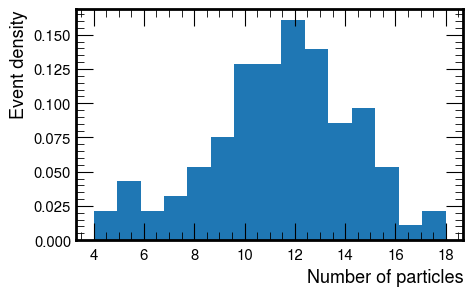

In [41]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("Number of particles")
ax.hist(num_particles, bins=15, density=True)
ax.set_ylabel("Event density")
fig.show()


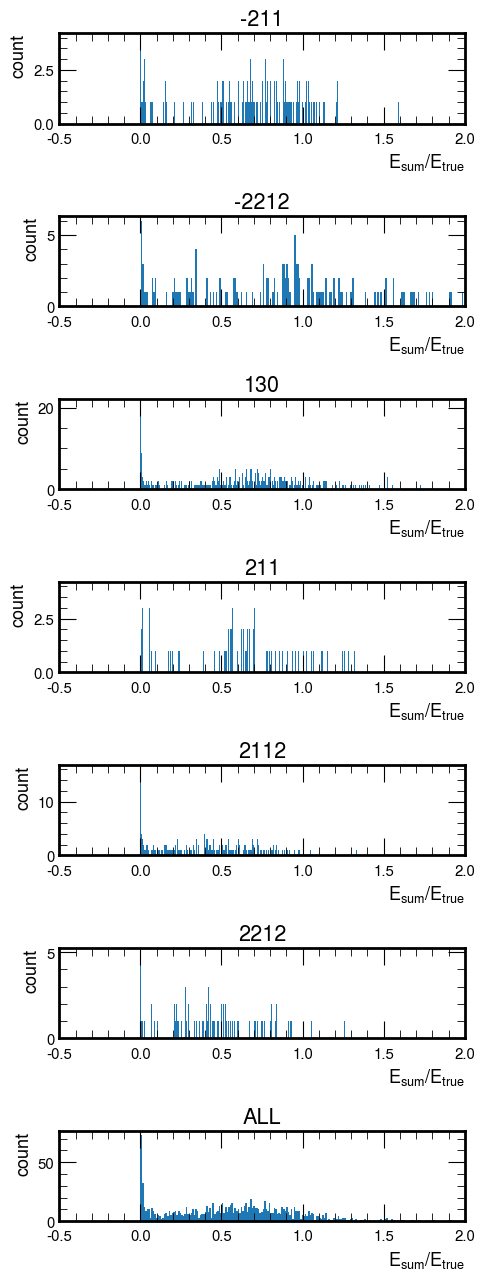

In [42]:
import matplotlib.pyplot as plt
all_ratios = {str(k): v for k, v in all_ratios.items()}
keys = sorted(list(all_ratios.keys()))
fig, ax = plt.subplots(len(keys), figsize=(5, 13))

for i in range(len(keys)):
    ax[i].hist(all_ratios[keys[i]], bins=400)
    ax[i].set_xlim(-0.5, 2)
    ax[i].set_ylabel("count")
    ax[i].set_xlabel(r"$E_{sum}/E_{true}$")
    ax[i].set_title(f"{keys[i]}")

fig.tight_layout()

#fig.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/new_dataset/energy_hist_corr1.pdf")
fig.show()

In [8]:
#import pickle
#pickle.dump(all_ratios, open("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/corr_ds/PID_filtered_energy_sum_vs_true.pkl", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: '/eos/home-g/gkrzmanc/PF_reports/initial_histograms/corr_ds/PID_filtered_energy_sum_vs_true.pkl'